## Using Random Forest to predict the next day regime

In [98]:
import yfinance as yf
import pandas as pd
import numpy as np

ml_df = yf.download('^GSPC', start="1978-01-01", interval="1d")

for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)
ml_df.dropna(inplace=True)
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()
ml_df.dropna(inplace=True)  

ml_df


/Users/alden/quantfin/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Close_7_Value,Volume_7_Value,Close_14_Value,Volume_14_Value,Close_21_Value,Volume_21_Value,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value
Date,,,,,,,,,,,,,,,,,,,,,
1978-03-02,0.000000,87.809998,86.690002,87.320000,87.320000,20280000,0.001491,-0.034745,0.003217,0.026835,...,-0.003083,-0.073550,-0.033001,0.130435,-0.021625,0.020634,0.005421,0.006257,0.005180,0.005714
1978-03-03,0.000000,87.980003,86.830002,87.449997,87.449997,20120000,0.001489,-0.007890,0.002982,-0.042361,...,-0.001256,0.090515,-0.029196,0.032854,-0.027577,-0.095324,0.000135,0.006300,0.005283,0.005400
1978-03-06,0.000000,87.519997,86.480003,86.900002,86.900002,17230000,-0.006289,-0.143638,-0.004810,-0.150394,...,-0.008444,-0.079594,-0.032940,0.024985,-0.035837,-0.252495,0.004502,0.006671,0.005401,0.005440
1978-03-07,0.000000,87.629997,86.550003,87.360001,87.360001,19900000,0.005293,0.154962,-0.001029,-0.010934,...,-0.012770,-0.115948,-0.018868,-0.027846,-0.025218,0.025773,0.005909,0.005604,0.005387,0.005567
1978-03-08,0.000000,88.080002,86.970001,87.839996,87.839996,22030000,0.005494,0.107035,0.010817,0.278584,...,0.001368,0.102051,-0.011145,0.092216,-0.018548,0.894239,0.006749,0.005250,0.005675,0.005755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,5108.029785,5127.970215,5092.220215,5104.759766,5104.759766,4559050000,0.005141,0.031830,-0.005104,-0.041902,...,0.006949,0.237551,0.020825,0.185524,0.032765,0.133066,0.007727,0.006087,0.007570,0.007460
2024-03-07,5132.379883,5165.620117,5128.209961,5157.359863,5157.359863,4137980000,0.010304,-0.092359,0.015498,-0.063469,...,0.015592,0.054007,0.025375,0.000002,0.041001,-0.068207,0.010667,0.007037,0.007854,0.007699
2024-03-08,5164.459961,5189.259766,5117.500000,5123.689941,5123.689941,4208870000,-0.006529,0.017132,0.003708,-0.076810,...,0.010638,0.110704,0.023598,0.097984,0.025751,-0.140273,0.008611,0.007697,0.007979,0.007769


In [99]:
# vix = yf.download('^VIX', start="1990-01-01", interval="1d")
# vix.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
# vix.index = pd.to_datetime(vix.index)
# vix.rename(columns={'Close':'VIX'}, inplace=True)

In [100]:
sp500_regimes = pd.read_csv('../data/sp500_regimes.csv')
sp500_regimes.set_index('Date', inplace=True)
sp500_regimes.index = pd.to_datetime(sp500_regimes.index)
ml_df.index = pd.to_datetime(ml_df.index)
data = pd.merge(ml_df.drop(columns=['High','Low','Open','Close','Adj Close']), sp500_regimes, on='Date',how='inner')
# data = pd.merge(data, vix, on='Date', how='inner')

In [101]:
# Assuming df is your DataFrame
# data['day_in_regime'] = data.groupby((data['color'] != data['color'].shift()).cumsum()).cumcount() + 1
# data.drop(columns=['Open','High','Close','Low'], inplace=True)

In [102]:
data['color'] = data['color'].shift(-1)
data.dropna(inplace=True)

In [103]:
X = data.drop(columns=['color'])
y = data['color']

In [104]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Counter(y_train)

Counter({'blue': 5938, 'red': 937, 'green': 923, 'pink': 727})

The data is skewed, this means classes are unqeually represented. This may affect model's performance. Hence, performing under/oversampling is recommended

## Performing oversampling of the smaller classes

In [105]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from sklearn.preprocessing import LabelEncoder

# Assuming X is your dataset and y is the target variable
oversampler = SMOTE()  # Choose your oversampler: RandomOverSampler, SMOTE, or ADASYN
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)


In [106]:
Counter(y_resampled)

Counter({'blue': 5938, 'pink': 5938, 'red': 5938, 'green': 5938})

We can see now that the classes are more equally represented

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=191, random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=191, random_state=42)

In [108]:
y_pred = rf.predict(X_test)
y_prob_pred = rf.predict_proba(X_test)

## Accuracy of model

In [109]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_score = accuracy_score(y_test, y_pred)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
acc_score

0.9798311444652908

## Confusion Matrix

Confusion Matrix:
[[1428   10   11    0]
 [   4  252    0    1]
 [   5    0  184    2]
 [   0    7    3  225]]


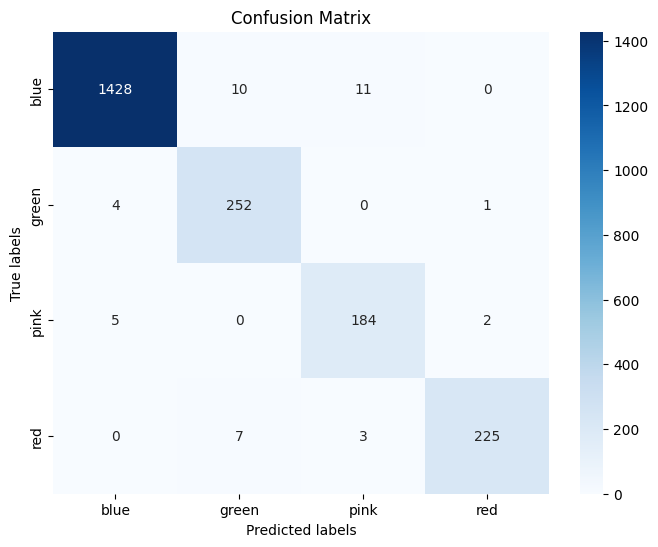

In [110]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = np.unique(y_test)

# Compute the confusion matrix with labels
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

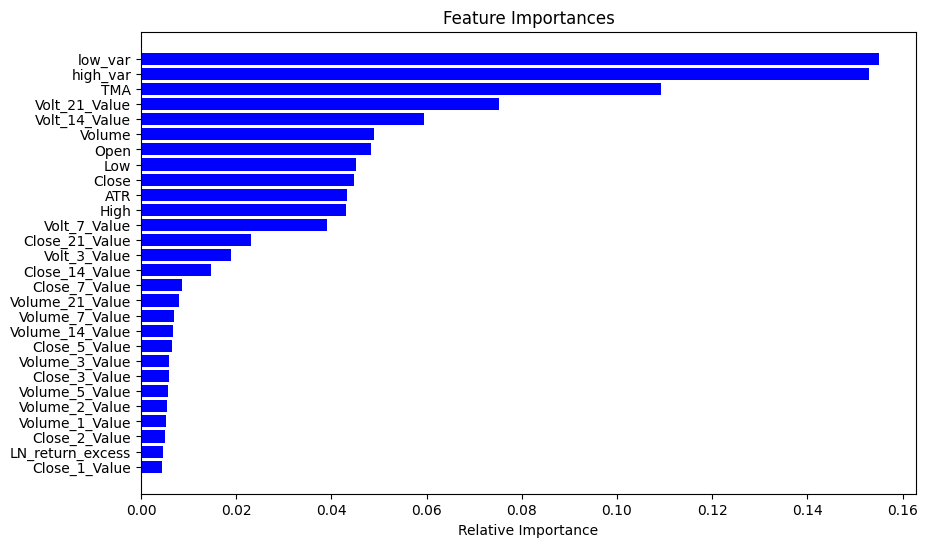

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Get the indices sorted by importance
indices = np.argsort(importances)

# Get the feature names
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [112]:
from sklearn.metrics import f1_score


f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' if you have a multi-class problem

print(f'F1 Score: {f1}')

F1 Score: 0.9799621268223112


In [71]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def rf_cv(n_estimators):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   random_state=42)
    return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

param_bounds = {'n_estimators': (10, 200)}

optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)

# Perform the optimization
optimizer.maximize(init_points=10, n_iter=15)

|   iter    |  target   | n_esti... |
-------------------------------------
| 1         | 0.9855    | 81.16     |
| 2         | 0.9866    | 190.6     |
| 3         | 0.9863    | 149.1     |
| 4         | 0.9858    | 123.7     |
| 5         | 0.9839    | 39.64     |
| 6         | 0.9839    | 39.64     |
| 7         | 0.9822    | 21.04     |
| 8         | 0.986     | 174.6     |
| 9         | 0.9856    | 124.2     |
| 10        | 0.9862    | 144.5     |
| 11        | 0.9858    | 113.4     |
| 12        | 0.9865    | 200.0     |
| 13        | 0.986     | 161.9     |
| 14        | 0.9854    | 64.61     |
| 15        | 0.9856    | 96.35     |
| 16        | 0.9863    | 183.3     |
| 17        | 0.9848    | 54.12     |
| 18        | 0.9865    | 195.3     |
| 19        | 0.9864    | 155.6     |
| 20        | 0.9858    | 118.6     |
| 21        | 0.986     | 105.2     |
| 22        | 0.9853    | 72.97     |
| 23        | 0.9859    | 137.7     |
| 24        | 0.9853    | 88.71     |
| 25        

In [72]:
print(optimizer.max)

{'target': 0.9866086353677748, 'params': {'n_estimators': 190.63571821788406}}
